**сиамская сеть, оцениваем схожесть текстов**

Евгений Борисов <esborisov@sevsu.ru>

## Библиотеки

In [1]:
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm.notebook import tqdm
# import gzip
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200  
tqdm.pandas()

def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
# каталог товаров
data = pd.read_excel('../data/okpd2.xlsx')
ppr(data)
data.sample(3)

записей: 19 464


,Код,Наименование,Комментарий
15645,32.40.39.172,Украшения елочные металлические электромеханические (с микроэлектродвигателями),NaN
11816,21.20.10.171,Антисептики и противомикробные препараты для лечения гинекологических заболеваний,NaN
11781,21.20.10.116,"Препараты противодиарейные, кишечные противовоспалительные и противомикробные",NaN


In [4]:
# нумеруем позиции каталога
data['id'] = range(len(data))
# будем использовать второй уровень каталога (две первые цифры)
data['group'] = data['Код'].str[:5]

In [5]:
# длина описаний в символах
data['Наименование'].str.len().describe([.95]).astype(int)

count    19464
mean        58
std         39
min          3
50%         50
95%        130
max        540
Name: Наименование, dtype: int64

In [6]:
# выкидываем короткие описания и дубликаты
data = data[ (data['group'].str.len()==5) & data['Наименование'].str.len().between(30,100) ]\
  .drop_duplicates(['Наименование'])[['id','group','Наименование']]\
  .reset_index(drop=True)

ppr(data)
data.sample(3)

записей: 9 632


,id,group,Наименование
7436,14920,29.31,Стартеры и стартер-генераторы для транспортных средств
4920,9809,14.19,Шапки швейные женские или для девочек
403,1083,46.24,Услуги по оптовой торговле шкурами и кожей


In [7]:
# формируем списки описаний по группам
groups =  data[['id','group']].groupby('group')['id'].apply(list).reset_index()
ppr(groups)

записей: 596


In [8]:
# количество описаний в группах
groups['id'].str.len().describe([.95]).astype(int)

count    596
mean      16
std       24
min        1
50%        7
95%       62
max      185
Name: id, dtype: int64

In [9]:
# выкидываем группы с малым количеством описаний, обрезаем большие списки
n_samples = 10

ppr(groups)
groups = groups[ groups['id'].str.len()> n_samples ].reset_index(drop=True)
ppr(groups)
groups['id'] = groups['id'].apply(rng.permutation).str[:n_samples]

записей: 596
записей: 227


In [10]:
# похожие примеры
groups['id_eq'] = groups['id'].apply(rng.permutation)

In [11]:
groups

,group,id,id_eq
0,01.11,"[1368, 6121, 6073, 6080, 2827, 6117, 6060, 6070, 2844, 18539]","[1368, 2844, 6121, 6073, 6117, 6060, 6080, 18539, 6070, 2827]"
1,01.13,"[2879, 2870, 1373, 6235, 6229, 1379, 1375, 6225, 1374, 6226]","[1373, 6226, 1374, 6225, 1379, 6235, 6229, 2870, 1375, 2879]"
2,01.15,"[18166, 6248, 18171, 18168, 18178, 6246, 18177, 18167, 18175, 18165]","[18166, 18168, 18165, 6246, 6248, 18178, 18177, 18175, 18171, 18167]"
3,01.16,"[6269, 2887, 6272, 6271, 6258, 6250, 6264, 6270, 6259, 6249]","[6269, 6250, 6271, 6264, 2887, 6259, 6270, 6258, 6272, 6249]"
4,01.19,"[6288, 6287, 6276, 6283, 2894, 6298, 2893, 6275, 6273, 6284]","[6298, 6288, 6283, 6275, 6273, 2893, 6284, 6276, 2894, 6287]"
...,...,...,...
222,95.29,"[19319, 19294, 19273, 19263, 6017, 19255, 19311, 19317, 19296, 19257]","[19317, 19319, 19273, 19296, 19255, 19263, 19294, 6017, 19257, 19311]"
223,96.01,"[19407, 19360, 19396, 19392, 19370, 19364, 19323, 19398, 19400, 19381]","[19407, 19323, 19398, 19360, 19400, 19392, 19396, 19370, 19364, 19381]"
224,96.02,"[1353, 6025, 2818, 19414, 19412, 2817, 19411, 19415, 6026, 6027]","[19415, 6027, 2818, 19412, 6026, 2817, 19411, 6025, 1353, 19414]"
225,96.03,"[19432, 19425, 19424, 19427, 1354, 19443, 19442, 19434, 6030, 19441]","[6030, 19441, 19442, 19427, 19425, 19432, 19424, 19434, 1354, 19443]"


In [12]:
# непохожие примеры

# пары из разных групп
groups_ = groups[['group']].reset_index(drop=True)
groups_['group_neq'] = rng.permutation(groups['group'])
groups_ = groups_.query('group!=group_neq')

groups_ = groups_.merge( groups[['group','id']]\
                          .rename(columns={'group':'group_neq','id':'id_neq'}), 
                        on=['group_neq'])

groups_['id_neq'] = groups_['id_neq'].apply(rng.permutation)

# groups[['group','id']].rename(columns={'group':'group_neq','id':'id_neq'})

groups_

,group,group_neq,id_neq
0,01.11,24.44,"[4036, 4035, 12688, 1902, 1901, 4043, 4037, 12690, 4041, 12691]"
1,01.13,01.15,"[18166, 18167, 18177, 18175, 6248, 6246, 18165, 18168, 18178, 18171]"
2,01.15,59.20,"[1198, 5475, 17055, 17054, 2586, 17035, 17056, 17046, 2587, 17037]"
3,01.16,25.71,"[13025, 13022, 4102, 13032, 13031, 13024, 13033, 1940, 4101, 943]"
4,01.19,03.21,"[3027, 7222, 778, 7245, 7241, 7226, 1447, 7243, 7219, 7225]"
...,...,...,...
220,95.29,30.92,"[15232, 15235, 2186, 2187, 15231, 15234, 1002, 2190, 15240, 15238]"
221,96.01,42.21,"[16175, 99, 84, 86, 2295, 95, 94, 93, 106, 1048]"
222,96.02,28.14,"[2064, 14059, 2063, 18768, 4405, 18772, 14058, 18775, 18778, 18771]"
223,96.03,52.22,"[16833, 16838, 16844, 16824, 16832, 1173, 16827, 16825, 16845, 16830]"


In [13]:
# группа, описания, похожие описания, непохожие описания
groups = groups.merge( groups_[['group','id_neq']], on=['group'] )
groups

,group,id,id_eq,id_neq
0,01.11,"[1368, 6121, 6073, 6080, 2827, 6117, 6060, 6070, 2844, 18539]","[1368, 2844, 6121, 6073, 6117, 6060, 6080, 18539, 6070, 2827]","[4036, 4035, 12688, 1902, 1901, 4043, 4037, 12690, 4041, 12691]"
1,01.13,"[2879, 2870, 1373, 6235, 6229, 1379, 1375, 6225, 1374, 6226]","[1373, 6226, 1374, 6225, 1379, 6235, 6229, 2870, 1375, 2879]","[18166, 18167, 18177, 18175, 6248, 6246, 18165, 18168, 18178, 18171]"
2,01.15,"[18166, 6248, 18171, 18168, 18178, 6246, 18177, 18167, 18175, 18165]","[18166, 18168, 18165, 6246, 6248, 18178, 18177, 18175, 18171, 18167]","[1198, 5475, 17055, 17054, 2586, 17035, 17056, 17046, 2587, 17037]"
3,01.16,"[6269, 2887, 6272, 6271, 6258, 6250, 6264, 6270, 6259, 6249]","[6269, 6250, 6271, 6264, 2887, 6259, 6270, 6258, 6272, 6249]","[13025, 13022, 4102, 13032, 13031, 13024, 13033, 1940, 4101, 943]"
4,01.19,"[6288, 6287, 6276, 6283, 2894, 6298, 2893, 6275, 6273, 6284]","[6298, 6288, 6283, 6275, 6273, 2893, 6284, 6276, 2894, 6287]","[3027, 7222, 778, 7245, 7241, 7226, 1447, 7243, 7219, 7225]"
...,...,...,...,...
220,95.29,"[19319, 19294, 19273, 19263, 6017, 19255, 19311, 19317, 19296, 19257]","[19317, 19319, 19273, 19296, 19255, 19263, 19294, 6017, 19257, 19311]","[15232, 15235, 2186, 2187, 15231, 15234, 1002, 2190, 15240, 15238]"
221,96.01,"[19407, 19360, 19396, 19392, 19370, 19364, 19323, 19398, 19400, 19381]","[19407, 19323, 19398, 19360, 19400, 19392, 19396, 19370, 19364, 19381]","[16175, 99, 84, 86, 2295, 95, 94, 93, 106, 1048]"
222,96.02,"[1353, 6025, 2818, 19414, 19412, 2817, 19411, 19415, 6026, 6027]","[19415, 6027, 2818, 19412, 6026, 2817, 19411, 6025, 1353, 19414]","[2064, 14059, 2063, 18768, 4405, 18772, 14058, 18775, 18778, 18771]"
223,96.03,"[19432, 19425, 19424, 19427, 1354, 19443, 19442, 19434, 6030, 19441]","[6030, 19441, 19442, 19427, 19425, 19432, 19424, 19434, 1354, 19443]","[16833, 16838, 16844, 16824, 16832, 1173, 16827, 16825, 16845, 16830]"


In [14]:
# разворачиваем в список пар
groups = pd.DataFrame({'id':groups['id'].explode(), 
              'id_eq':groups['id_eq'].explode(),
              'id_neq':groups['id_neq'].explode()})
ppr(groups)
groups.sample(3)

записей: 2 250


,id,id_eq,id_neq
194,17054,17054,13612
77,11416,11451,3526
151,14973,14964,11965


In [15]:
# формируем датасет
pair = groups[['id','id_eq']].rename(columns={'id':'id_L','id_eq':'id_R'})
pair['target'] = 1
pair = pd.concat([ pair, groups[['id','id_neq']]\
           .rename(columns={'id':'id_L','id_neq':'id_R'}) ])\
           .fillna(0).astype(int)

pair.sample(3)

,id_L,id_R,target
206,2700,5745,1
106,4089,1932,1
198,5562,18266,0


In [16]:
%xdel groups
%xdel groups_

## очистка данных

In [17]:
# data['ttext_clean'] = data['ttext']\
#     .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
#     .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
#     .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

In [18]:
# data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [19]:
data['ttext_clean'] = data['Наименование'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

In [20]:
data.sample(3)

,id,group,Наименование,ttext_clean
6350,12538,24.20,Трубы стальные бесшовные высокого давления,"[трубы, стальные, бесшовные, высокого, давления]"
1349,2806,94.99,"Услуги прочих общественных организаций, не включенные в другие группировки","[услуги, прочих, общественных, организаций, не, включенные, в, другие, группировки]"
3199,6818,02.20,Бревна еловые для опор линий связи и электропередач,"[бревна, еловые, для, опор, линий, связи, и, электропередач]"


In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 9 632
записей: 9 632


In [22]:
data.sample(3)

,id,group,Наименование,ttext_clean
9428,19216,95.24,Услуги по ремонту мягкой мебели,"[услуги, по, ремонту, мягкой, мебели]"
2487,5369,52.24,Услуги по обработке контейнеров в портах,"[услуги, по, обработке, контейнеров, в, портах]"
6736,13394,26.30,"Станции пожарной сигнализации, приборы управления и оповещатели пожарные","[станции, пожарной, сигнализации, приборы, управления, и, оповещатели, пожарные]"


In [23]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 9 976


## кодируем слова

In [24]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

  0%|          | 0/9632 [00:00<?, ?it/s]

In [25]:
data[['ttext_clean','code']].sample(3)

,ttext_clean,code
8595,"[бараны, производители, чистопородные, племенные, полутонкорунных, пород]","[401, 6572, 9527, 5863, 6206, 6262]"
9491,"[услуги, по, ремонту, платочно, шарфовых, изделий]","[8968, 5911, 7148, 5848, 9569, 2460]"
9601,"[услуги, по, косметическому, татуажу, пирсингу]","[8968, 5911, 3359, 8373, 5755]"


In [26]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    9632
mean        7
std         2
min         2
25%         5
50%         7
75%         9
max        16
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

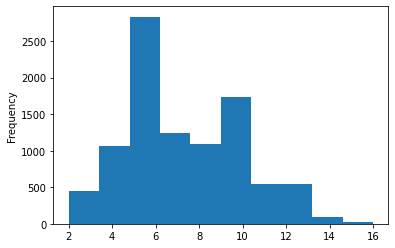

In [27]:
data['code'].str.len().plot.hist()

In [28]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

16

In [29]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

  0%|          | 0/9632 [00:00<?, ?it/s]

In [30]:
data['code'].str.len().describe().astype(int)

count    9632
mean       16
std         0
min        16
25%        16
50%        16
75%        16
max        16
Name: code, dtype: int64

In [31]:
# data

## строим датасет

In [32]:
pair

,id_L,id_R,target
0,1368,1368,1
0,6121,2844,1
0,6073,6121,1
0,6080,6073,1
0,2827,6117,1
...,...,...,...
224,19463,12950,0
224,19447,12949,0
224,19449,18597,0
224,19451,18608,0


In [33]:
dataset = pair\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )
ppr(dataset)
dataset.sample(3)

записей: 4 500


,id_L,id_R,target,code_L,code_R
1037,19005,3159,0,"[8968, 5911, 2447, 3337, 3997, 5911, 2544, 2206, 4544, 0, 0, 0, 0, 0, 0, 0]","[5025, 3479, 2833, 2416, 1566, 2250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3891,16219,14324,0,"[6818, 8180, 2416, 7145, 7458, 7317, 1470, 6611, 0, 0, 0, 0, 0, 0, 0, 0]","[4928, 1266, 2416, 6799, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3640,13625,1998,1,"[5606, 1095, 7317, 9458, 4144, 1103, 850, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[9472, 1103, 850, 3479, 9459, 4143, 2416, 9460, 0, 0, 0, 0, 0, 0, 0, 0]"


In [34]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((4500, 16), (4500, 16), (4500, 1))

In [35]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [36]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((4500, 16), (4500, 16), (4500, 1), 9974)

In [37]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [38]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

16

In [39]:
# from sklearn.model_selection import train_test_split
# from matplotlib import pyplot as plt

In [40]:
# # отделяем тестовый набор
# x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [41]:
# x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
# y_train = y_train.flatten()
# x_left_train.shape, x_right_train.shape, y_train.shape

In [42]:
# x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
# y_test = y_test.flatten()
# x_left_test.shape, x_right_test.shape, y_test.shape

In [43]:
# %xdel x_left
# %xdel x_right
# %xdel target

In [44]:
# gc.collect()

In [45]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [46]:
embed_len = 128
embed_input_dim, embed_len, seq_len

(9974, 128, 16)

In [47]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.8.0', '2.8.0')

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss
from tensorflow import cast

$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

In [49]:
def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

In [50]:
# from matplotlib import pyplot as plt
# y = np.ones(10)
# p = np.linspace(0,1,10)
# # y = np.zeros(10)
# # p = np.linspace(1,0,10)
# plt.plot( y*(p**2) + (1-y)*((1-p)**2) )

In [51]:
embed_input_dim,seq_len,embed_len

(9974, 16, 128)

In [52]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

2022-03-16 15:04:22.468604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:04:22.533258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:04:22.533444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2022-03-16 15:04:22.534617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 15:04:22.535013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:04:22.535177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:04:22.535309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [53]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

# классификатор
predictions = Dense(1, activation='relu')(merged)

# создаём модель
model = Model([input_l,input_r], predictions )

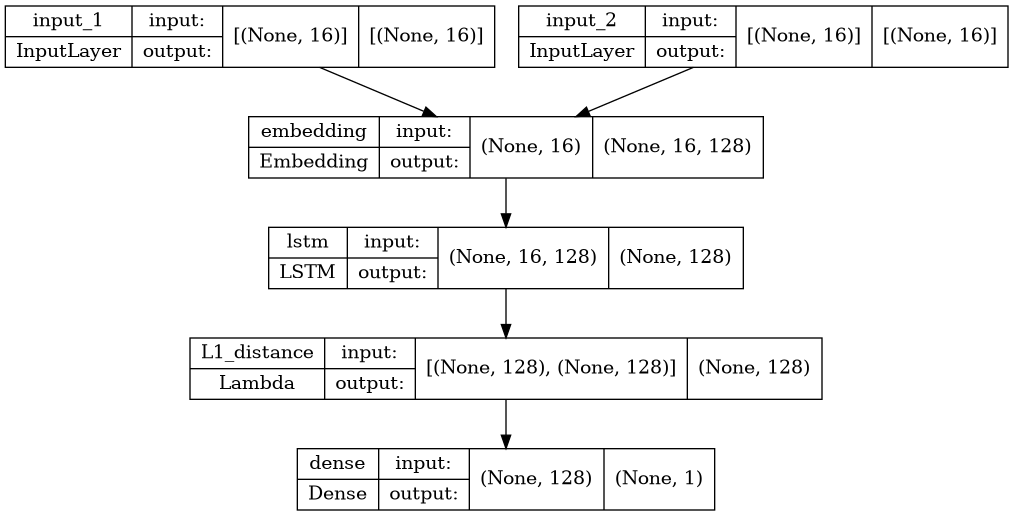

In [54]:
plot_model(model, show_layer_names=True, show_shapes=True )

In [55]:
learning_rate = 9e-3
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [56]:
x_left.shape,target.shape

((4500, 16), (4500, 1))

In [57]:
%%time

n_epochs = 25

history = model.fit( [x_left, x_right], target,epochs = n_epochs, batch_size = 1024, )

Epoch 1/25
5/5 [==============================] - 2s 33ms/step - loss: 0.3409 - acc: 0.4524
Epoch 2/25
5/5 [==============================] - 0s 38ms/step - loss: 0.1571 - acc: 0.2202
Epoch 3/25
5/5 [==============================] - 0s 37ms/step - loss: 0.0984 - acc: 0.1018
Epoch 4/25
5/5 [==============================] - 0s 31ms/step - loss: 0.0710 - acc: 0.0531
Epoch 5/25
5/5 [==============================] - 0s 32ms/step - loss: 0.0507 - acc: 0.0278
Epoch 6/25
5/5 [==============================] - 0s 32ms/step - loss: 0.0365 - acc: 0.0162
Epoch 7/25
5/5 [==============================] - 0s 30ms/step - loss: 0.0246 - acc: 0.0062
Epoch 8/25
5/5 [==============================] - 0s 34ms/step - loss: 0.0165 - acc: 0.0036
Epoch 9/25
5/5 [==============================] - 0s 35ms/step - loss: 0.0103 - acc: 0.0013
Epoch 10/25
5/5 [==============================] - 0s 35ms/step - loss: 0.0060 - acc: 6.6667e-04
Epoch 11/25
5/5 [==============================] - 0s 32ms/step - loss: 0.0

----

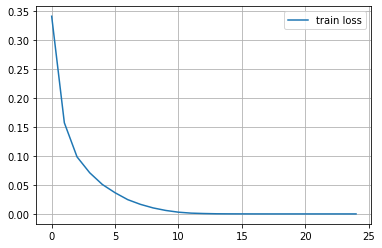

In [58]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

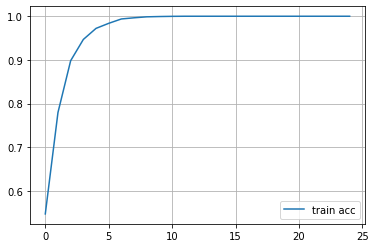

In [59]:
plt.plot( 1. - np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [60]:
# gc.collect()

## тест

In [61]:
# dataset.sample(2)

In [62]:
dataset['dist'] = model.predict([x_left,x_right,])

In [63]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_R','Наименование':'ttext_R'}),on='id_R')\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_L','Наименование':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]

# data_dist.sample(3)

In [64]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,4500.0,0.822694,0.869147,0.0,0.0,0.504612,1.562503,3.397567


In [65]:
# похожие тексты
data_dist[ (data_dist['dist']<0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(10)

,ttext_L,ttext_R,dist
3428,Ограды (заборы) и ограждения прочие,Сооружения для занятий спортом и отдыха,0.0
1129,Услуги центрального аппарата Следственного комитета Российской Федерации,Услуги федеральных арбитражных судов округов,0.0
4042,"Работы по укладке ковровых покрытий, линолеума и прочих гибких материалов для покрытия полов","Работы по устройству полов из тераццо, работы с использованием мрамора, гранита и сланца",0.0
1190,Дистилляты прочие полного цикла производства,Ликероводочные изделия крепостью свыше 25 % прочие,0.0
2920,Барабаны деревянные для электрических кабелей и проводов,Комплекты бочковые и бочки заливные,0.0
4334,Прицепы и полуприцепы типа фургонов для проживания или отдыха на природе,Контейнеры общего назначения (универсальные),0.0
3524,Изделия санитарно-технические аналогичные пластмассовые,Изделия пластмассовые строительные,0.0
3496,Профили фасонные пластмассовые,Покрытия полимерные защитные для улучшения радиационной обстановки,0.0
227,Металлоконструкции строительные и их части,Конструкции детали для шахтного строительства из черных металлов,0.0
786,Работы с целью оказания медицинской помощи,"Услуги радиолокационных станций, расположенных в аэропортах",0.0


In [66]:
# НЕпохожие тексты
data_dist[ (data_dist['dist']>0.5) ].sample(10)

,ttext_L,ttext_R,dist
4357,Мотоциклы с поршневым двигателем внутреннего сгорания с рабочим объемом цилиндров не более 50 см3,Услуги по ремонту электрооборудования прочих автотранспортных средств,1.263635
3601,"Услуги по чистовой обработке прочих стеклянных изделий, включая технические стеклянные изделия",Услуги по заграничным и каботажным перевозкам морскими судами сухих сыпучих грузов,1.440093
971,Нефть смесевая особо высокосернистая особо легкая,Рыба и филе рыбное холодного копчения,1.388784
1409,"Услуги по производству ювелирных и соответствующих изделий отдельные, выполняемые субподрядчиком",Услуги по бронированию и взаимосвязанные услуги прочие,1.094095
1895,"Игры и игрушки, не включенные в другие группировки",Панели и прочие комплекты электрической аппаратуры коммутации или защиты на напряжение не более 1 кВ,1.318040
1371,"Услуги по сбору неопасных отходов городского хозяйства, непригодных для повторного использования",Трубы и муфты асбестоцементные безнапорные,1.437839
3199,Работы строительные по строительству открытых плавательных бассейнов,Материалы смазочные; присадки; антифризы,1.363696
1613,Мороженое мягкое с заменителем молочного жира,Красители органические синтетические прочие,1.221022
687,Акула-молот свежая или охлажденная,Работы строительные по строительству фуникулеров и подвесных дорог,1.638706
1727,"Изделия хлебобулочные; мучные кондитерские изделия, торты и пирожные недлительного хранения",Услуги кафе с полным обслуживанием без сопровождения развлекательных программ,2.524899
